In [1]:
from mazelib import *
import numpy as np
import matplotlib.pyplot as plt

In [74]:

def showPNG(grid, axis=False):
    """Generate a simple image of the maze."""
    plt.figure(figsize=(10, 5))
    plt.imshow(grid, cmap=plt.cm.binary, interpolation='nearest')
    if not axis:
        plt.xticks([]), plt.yticks([])
    plt.show()
    
    
def unpack(solution):
    '''Unpack maze solution to numpy array'''
    x = []
    y = []
    for element in solution[0]:
        x_, y_ = element
        x.append(x_)
        y.append(y_)
    return np.stack((x,y), axis=1)

In [75]:
m = Maze()

In [76]:
m.generator = Prims(3,3)

In [77]:
m.solver = WallFollower()

In [78]:
mazes = m.generate_monte_carlo(10, 10, 1.0)
## Generate 10 different mazes
## Generate 10 different pairs of start/end 
## Rank mazes by the lenght of the solution. The shortest the easier

#### Take 1 solution of the 10 generated mazes

In [79]:
# Get desired maze
grid = mazes[9]['grid']
solution = unpack(mazes[9]['solutions'])
start = np.array(mazes[9]['start'])
end = np.array(mazes[9]['end'])

In [80]:
start

array([0, 5])

In [81]:
end

array([6, 3])

In [82]:
solution

array([[1, 5],
       [1, 4],
       [1, 3],
       [1, 2],
       [1, 1],
       [2, 1],
       [3, 1],
       [3, 2],
       [3, 3],
       [4, 3],
       [5, 3]])

Text(0.5, 1.0, 'maze')

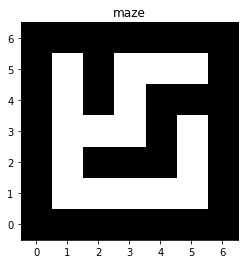

In [83]:
plt.imshow(grid, cmap=plt.cm.binary, 
           interpolation='nearest', origin='lower')

plt.title('maze')

In [84]:
# Clear entrances / Set entrances to 0
grid[start[0], start[1]] = 0
grid[end[0], end[1]] = 0

Text(0.5, 1.0, 'maze w/ cleared io')

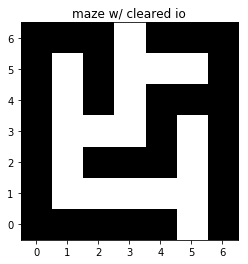

In [85]:
plt.imshow(grid, cmap=plt.cm.binary, 
           interpolation='nearest', origin='lower')

plt.title('maze w/ cleared io')

In [86]:
# and start and end to solution
solution = np.concatenate((start.reshape(1,2), solution, 
                    end.reshape(1,2)), axis=0)

In [87]:
solution

array([[0, 5],
       [1, 5],
       [1, 4],
       [1, 3],
       [1, 2],
       [1, 1],
       [2, 1],
       [3, 1],
       [3, 2],
       [3, 3],
       [4, 3],
       [5, 3],
       [6, 3]])

In [88]:
# Paint desired solution path
canvas = np.zeros((7,7))

# Set solution pixels to 1
for pixel in solution:
    canvas[pixel[0], pixel[1]]= 0.5
    

Text(0.5, 1.0, 'path planning')

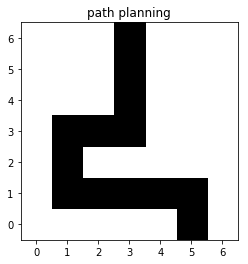

In [89]:
plt.imshow(canvas, cmap=plt.cm.binary, 
           interpolation='nearest', origin='lower')

plt.title('path planning')

In [90]:
# Sum of path planning + maze
res = grid + canvas

Text(0.5, 1.0, 'Grid + path planning')

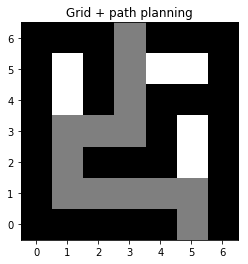

In [91]:
plt.imshow(res, cmap=plt.cm.binary, 
           interpolation='nearest', origin='lower')

plt.title('Grid + path planning')

(0, 6)

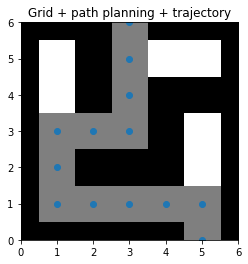

In [92]:
plt.imshow(res, cmap=plt.cm.binary, 
           interpolation='nearest', origin='lower')

plt.title('Grid + path planning + trajectory')
plt.scatter(solution[:, 1], solution[:, 0])
plt.xlim((0,6))
plt.ylim((0,6))

### Upsample image and generate family of trajectories
    We should upsample the maze without deforming cartesian

In [93]:
from skimage.transform import resize

In [94]:
res

array([[1. , 1. , 1. , 1. , 1. , 0.5, 1. ],
       [1. , 0.5, 0.5, 0.5, 0.5, 0.5, 1. ],
       [1. , 0.5, 1. , 1. , 1. , 0. , 1. ],
       [1. , 0.5, 0.5, 0.5, 1. , 0. , 1. ],
       [1. , 0. , 1. , 0.5, 1. , 1. , 1. ],
       [1. , 0. , 1. , 0.5, 0. , 0. , 1. ],
       [1. , 1. , 1. , 0.5, 1. , 1. , 1. ]])

In [95]:
res.shape

(7, 7)

#### Upsample maze to 64x64

In [96]:
rr = resize(res, (64,64), order=0)

/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [97]:
rr.shape

(64, 64)

#### Upsample trajectory

In [98]:
up_factor = 64/7

up_trajectory = solution*up_factor + 4

(0, 63)

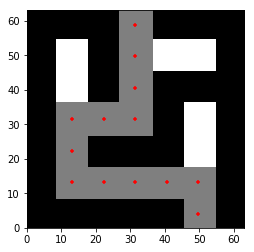

In [99]:
#plt.figure(figsize=(10, 10))

plt.imshow(rr, cmap=plt.cm.binary, 
           interpolation='nearest', 
           origin='lower')

plt.scatter(up_trajectory[:, 1], up_trajectory[:, 0],s=10 , c='r', marker='+')

plt.xlim((0,63))
plt.ylim((0,63))

#### update path planning

In [100]:
rr_sol = resize(canvas, (64,64), order=0)

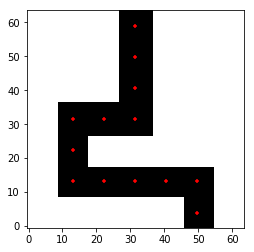

In [101]:
plt.imshow(rr_sol, cmap=plt.cm.binary, 
           interpolation='nearest', 
           origin='lower')
plt.scatter(up_trajectory[:, 1], up_trajectory[:, 0],s=10 , c='r', marker='+')


#### Get road size

In [102]:
road_size_x = []
road_size_y = []

for i in range(63):
    sec = rr_sol[i, :]  # get section
    rows = np.where(sec == 0.5)  # where is the road?  
    
    if rows[0].any():
        max_ = np.max(rows) - np.min(rows)  # max road size in pixels
        road_size_x.append(max_)
    else:
        road_size_x.append(0)

for i in range(63):
    sec = rr_sol[:, i]  # get section
    rows = np.where(sec == 0.5)  # where is the road?  
    
    if rows[0].any():
        max_ = np.max(rows) - np.min(rows)  # max road size in pixels
        road_size_y.append(max_)
    else:
        road_size_y.append(0)

        
print('Most likely road size x = ', np.unique(road_size_x))
print('Most likely road size y = ', np.unique(road_size_y))
print('Most likely road size xy = ', np.unique(np.stack((road_size_x, road_size_y)))[1])

Most likely road size x =  [ 8  9 27 45]
Most likely road size y =  [ 0  8 17 27 54]
Most likely road size xy =  8


#### Perturbate trajectories

In [103]:
# We scan the desired trajectory and detect points where the trajectory changes
# We perturbate a point in the middle adding a random integer
# Perturbations can be feasible or unfeasible
up_trajectory

array([[ 4.        , 49.71428571],
       [13.14285714, 49.71428571],
       [13.14285714, 40.57142857],
       [13.14285714, 31.42857143],
       [13.14285714, 22.28571429],
       [13.14285714, 13.14285714],
       [22.28571429, 13.14285714],
       [31.42857143, 13.14285714],
       [31.42857143, 22.28571429],
       [31.42857143, 31.42857143],
       [40.57142857, 31.42857143],
       [49.71428571, 31.42857143],
       [58.85714286, 31.42857143]])

In [104]:
dif = np.diff(up_trajectory, axis=0)
dif

array([[ 9.14285714,  0.        ],
       [ 0.        , -9.14285714],
       [ 0.        , -9.14285714],
       [ 0.        , -9.14285714],
       [ 0.        , -9.14285714],
       [ 9.14285714,  0.        ],
       [ 9.14285714,  0.        ],
       [ 0.        ,  9.14285714],
       [ 0.        ,  9.14285714],
       [ 9.14285714,  0.        ],
       [ 9.14285714,  0.        ],
       [ 9.14285714,  0.        ]])

In [153]:
mu = 9
sigma = 2

def perturbation(mu, sigma=1.5):
    return np.random.normal(mu, sigma, 1)[0]


In [160]:

new_points = [] 

# Append entrance (point A)
new_points.append(up_trajectory[0])
# Calculate diff with second point
diff = up_trajectory[1] - up_trajectory[0]
# Detect if there is any zero on x ot y
past_x_flag, past_y_flag = diff == 0

#print(past_x_flag)
#print(past_y_flag)

for i in range(1, len(up_trajectory)-1):

    # Calculate diff from the next point
    diff = up_trajectory[i+1] - up_trajectory[i]
    # Check if any of the coordinates have a 0
    current_x_flag, current_y_flag = diff == 0
    

    x, y = up_trajectory[i]
    
    if current_x_flag == past_x_flag and current_x_flag == past_x_flag: ### ALL flags are equal
        new_point = np.array([perturbation(x), perturbation(y)])
        print('both equal pertubation') 
    else:   #### Flags are different
        #if current_x_flag == past_x_flag: 
        #    new_point = np.array([x, y + 2])
        #    print('horizontal perturbation')

        #elif current_y_flag == past_y_flag:    
            # Movement in vertical direction / perturbate X
        #    new_point = np.array([x + 2, y])
        #    print('vertical perturbation')  
            
        #else:  # Anchor point
        # Transition point end_anchor
        print('anchor point do not perturbate')
        new_point = np.array([x,y])
    
    # Update flag
    past_x_flag = current_x_flag
    past_y_flag = current_y_flag
        
    # Append point
    new_points.append(new_point)
    
new_points.append(up_trajectory[-1])
new_points = np.array(new_points)

anchor point do not perturbate
both equal pertubation
both equal pertubation
both equal pertubation
anchor point do not perturbate
both equal pertubation
anchor point do not perturbate
both equal pertubation
anchor point do not perturbate
both equal pertubation
both equal pertubation


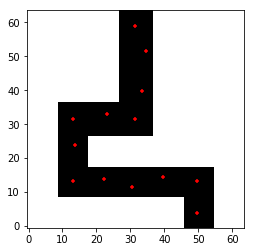

In [161]:
plt.imshow(rr_sol, cmap=plt.cm.binary, 
           interpolation='nearest', 
           origin='lower')
plt.scatter(new_points[:, 1], new_points[:, 0],s=10 , c='r', marker='+')


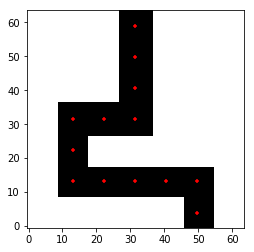

In [162]:
plt.imshow(rr_sol, cmap=plt.cm.binary, 
           interpolation='nearest', 
           origin='lower')
plt.scatter(up_trajectory[:, 1], up_trajectory[:, 0],s=10 , c='r', marker='+')
